In [1]:
import pandas as pd
import numpy as np
import sys , os 
import seaborn as sns 
import sklearn as sk
from sklearn.metrics import classification_report,matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle 
sns.set_style(style="whitegrid")

PDB_BM5 = [
'1EXB','1JTD','1M27','1RKE','2A1A','2GAF','2GTP','2VXT','2W9E',
'2X9A','2YVJ','3A4S','3AAA','BAAD','3AAD','3BIW','3BX7',
'3DAW','3EO1','3EOA','3F1P','3FN1','3G6D','3H11',
'3H2V','3HI6','3HMX','3K75','3L5W','3L89','3LVK','3MXW',
'BP57','CP57','3P57','3PC8','3R9A','3RVW','3S9D','3SZK',
'3V6Z','3VLB','4DN4','4FQI','4FZA','4G6J','4G6M','4GAM',
'4GXU','4H03','4HX3','4IZ7','4JCV','4LW4','4M76'
]

"""use the ML_env to reproduce the results reported"""

'use the ML_env to reproduce the results reported'

In [2]:
print (f"Numpy version:{np.__version__}")
print (f"Pandas version:{pd.__version__}")
print (f"Sklearn version:{sk.__version__}")

Numpy version:1.18.5
Pandas version:1.2.1
Sklearn version:0.23.2


In [3]:
def load_data_sets():
    all_balanced_data = pd.read_csv("../data/Clean_dataframe_balanced_all_data_ccharppi_4_march_2020_complete.csv",dtype={'class_q': 'object'})
    all_balanced_data.set_index('Conf',inplace=True)
    all_balanced_data.loc["Z_1JTG_1136_M.pdb","DDG_V"]  = all_balanced_data["DDG_V"].mean()
    print (all_balanced_data.shape)
    all_unbalanced_data = pd.read_csv("../data/Clean_dataframe_unbalanced_all_data_ccharppi_4_march_2020_complete.csv",dtype={'class_q': 'object'})
    all_unbalanced_data.set_index('Conf',inplace=True)
    all_unbalanced_data.loc["Z_1JTG_1136_M.pdb","DDG_V"]  = all_balanced_data["DDG_V"].mean()


    Scorers_balanced_data = pd.read_csv("../data/Clean_dataframe_balanced_scorers_set.csv")
    
    print (Scorers_balanced_data.shape)


    Scorers_balanced_data.set_index('Conf',inplace=True)
    Scorers_balanced_data.dropna(inplace=True)

    Scorers_unbalanced_data = pd.read_csv("../data/Clean_dataframe_unbalanced_scorers_set.csv")


    Scorers_unbalanced_data.set_index('Conf',inplace=True)
    Scorers_unbalanced_data.dropna(inplace=True)

    X_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]
    y_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')

    
    X_val = all_balanced_data[all_balanced_data["idx"].isin(PDB_BM5) ]
    y_val = all_balanced_data[all_balanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')
    #         print (X_test.size,y_test.size)
       
    X_val_u = all_unbalanced_data[all_unbalanced_data["idx"].isin(PDB_BM5) ]
    y_val_u = all_unbalanced_data[all_unbalanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')
    
    X_test = Scorers_balanced_data
    y_test = Scorers_balanced_data["binary_label"].astype('bool')
    
    X_test_u = Scorers_unbalanced_data
    y_test_u = Scorers_unbalanced_data["binary_label"].astype('bool')
    
    X_test_u.rename(columns={'NIS Polar' :'Nis_Polar',
                                  'Nis Apolar':'Nis_Apolar',
                                  'BSA Apolar':'BSA_Apolar',
                                  'BSA Polar' :'BSA_Polar',
                                'binary_label':'label_binary'
                            },inplace=True)
    X_test.rename(columns={'NIS Polar' :'Nis_Polar',
                                  'Nis Apolar':'Nis_Apolar',
                                  'BSA Apolar':'BSA_Apolar',
                                  'BSA Polar' :'BSA_Polar',
                                   'binary_label':'label_binary'
                          },inplace=True)
    

    return X_train, y_train , X_val, y_val, X_test, y_test ,X_val_u, y_val_u, X_test_u, y_test_u 

In [4]:
X_train, y_train , X_val, y_val, X_test, y_test ,X_val_u, y_val_u, X_test_u, y_test_u  = load_data_sets()

(73684, 161)
(3990, 162)


In [5]:
def scaling_data_selected(X_train,X_test,X_test_unbalanced):

    scaler = StandardScaler()


    selected_feat = ['CONSRANK_val','AP_GOAP_DF','CP_TD','CP_D1','CP_HLPL',
                      'DDG_V','CP_MJ3h','PYDOCK_TOT','ELE','CP_SKOIP',
                      'SIPPER','AP_DFIRE2','AP_dDFIRE','AP_PISA','CP_RMFCA',

                     ]
    
    X_train = X_train[selected_feat]
    X_test = X_test[selected_feat]
    X_test_unbalanced= X_test_unbalanced[selected_feat]


    scaler.fit(X_train)
    
    filename = '../models/scaler_CODES_BM4_selected_features.sav'
    pickle.dump(scaler, open(filename, 'wb'))
    
    scaled_train = scaler.transform(X_train)
    scaled_test = scaler.transform(X_test)
    scaled_test_u = scaler.transform(X_test_unbalanced)

    return scaled_train,scaled_test,scaled_test_u

In [6]:
def scaling_data(X_train,X_test,X_test_unbalanced):
    features = ['idx','class_q','pdb1','chains_pdb1','pdb2','chains_pdb2',
                'label_binary','DQ_val','binary_label','identification','labels']
    scaler = StandardScaler()

    for x in features :
        if x in X_train.columns:
            X_train= X_train.drop(x,axis=1)            
    for x in features :
        if x in X_test.columns: 
                X_test = X_test.drop(x,axis=1)
            
    for x in features :
        if x in X_test_unbalanced.columns:
            X_test_unbalanced= X_test_unbalanced.drop(x,axis=1)

    scaler.fit(X_train)
    
    filename = '../models/scaler_CODES_BM4_all_features.sav'
    pickle.dump(scaler, open(filename, 'wb'))
    
    scaled_train = scaler.transform(X_train)
    scaled_test = scaler.transform(X_test)
    scaled_test_u = scaler.transform(X_test_unbalanced)
    return scaled_train,scaled_test,scaled_test_u

In [7]:

rfc_sel_feat = RandomForestClassifier(n_jobs=-1,
                                         n_estimators=100,
                                         random_state=32,
                                         min_samples_split= 10 , 
                                         class_weight={0:1.2,1:0.1})

In [8]:
X_train_fs, X_test_fs, X_test_u_fs = scaling_data_selected(X_train, X_test, X_test_u)
X_train_fs, X_val_fs, X_val_u_fs = scaling_data_selected(X_train, X_val, X_val_u)

In [9]:
np.random.seed(seed = 101) 

rfc_sel_feat.fit(X_train_fs,y_train)

RandomForestClassifier(class_weight={0: 1.2, 1: 0.1}, min_samples_split=10,
                       n_jobs=-1, random_state=32)

In [10]:
filename = '../models/RFC_CODES_features_selected.sav'
pickle.dump(rfc_sel_feat, open(filename, 'wb'))

In [11]:
def save_metrics_results(model,x_test,y_test,tag):
    # target_names = ['Incorrect', 'Correct']

    y_pred = model.predict(x_test)
    cr = classification_report(y_true=y_test, y_pred=y_pred,output_dict=True)
    mmc = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
    # print (cr)
    acc = cr["accuracy"]
    rec_false = cr["False"]["recall"]
    rec_true  = cr["True"]["recall"]
    pres_false = cr["False"]["precision"]
    pres_true = cr["True"]["precision"]
    f1_false =  cr["False"]["f1-score"]
    f1_true =  cr["True"]["f1-score"]

    results = {
        "Accuracy": acc,
        "Recall_inc":rec_false,
        "Recall_cor":rec_true,
        "Precision_inc":pres_false ,
        "Precision_cor":pres_true,
        "F1_inc":f1_false,
        "F1_cor":f1_true,
        "MCC":mmc
    }
    mean_df = pd.DataFrame(data=results,index=[f"{tag}"])
    return mean_df


In [23]:
y_pred= rfc_sel_feat.predict(X_test_u_fs)

In [24]:
print (classification_report( y_true=y_test_u ,y_pred= y_pred))

              precision    recall  f1-score   support

       False       1.00      0.67      0.80     16618
        True       0.28      0.99      0.44      2160

    accuracy                           0.71     18778
   macro avg       0.64      0.83      0.62     18778
weighted avg       0.91      0.71      0.76     18778



In [25]:
y_pred= rfc_sel_feat.predict(X_val_u_fs)

In [26]:
print (classification_report( y_true=y_val_u,y_pred= y_pred))

              precision    recall  f1-score   support

       False       0.99      0.92      0.95    146541
        True       0.46      0.90      0.61     11226

    accuracy                           0.92    157767
   macro avg       0.73      0.91      0.78    157767
weighted avg       0.95      0.92      0.93    157767



In [27]:
validation = save_metrics_results(model=rfc_sel_feat,
                                  x_test=X_val_u_fs,
                                  y_test=y_val_u,
                                  tag="BM5 update")


In [28]:
print ( validation.T.to_latex() ) 

\begin{tabular}{lr}
\toprule
{} &  BM5 update \\
\midrule
Accuracy      &    0.918259 \\
Recall\_inc    &    0.919743 \\
Recall\_cor    &    0.898895 \\
Precision\_inc &    0.991649 \\
Precision\_cor &    0.461788 \\
F1\_inc        &    0.954343 \\
F1\_cor        &    0.610134 \\
MCC           &    0.609263 \\
\bottomrule
\end{tabular}



In [29]:
test = save_metrics_results(model=rfc_sel_feat,
                            x_test=X_test_u_fs,
                            y_test=y_test_u,
                            tag="Score_set")


In [30]:
print ( test.T.to_latex() ) 

\begin{tabular}{lr}
\toprule
{} &  Score\_set \\
\midrule
Accuracy      &   0.707317 \\
Recall\_inc    &   0.671200 \\
Recall\_cor    &   0.985185 \\
Precision\_inc &   0.997139 \\
Precision\_cor &   0.280295 \\
F1\_inc        &   0.802331 \\
F1\_cor        &   0.436423 \\
MCC           &   0.426736 \\
\bottomrule
\end{tabular}



In [31]:
def get_success_rate(df,sel):
    """this funtion read a pandas dataframe and that dataframe need the columns
    idx , proba_true , and the label_binary"""
    total_size = {"val":float(len(PDB_BM5)),"test":float(15)}
    
    tops = [1,10,100,1000]
    tcount = [0 for y in range(len(tops))]
    names = [ [] for y in range(len(tops))]
    ranks = []
    for m in df['idx'].unique():
#         print (m, end=" ")
        found = False
        count = 0
        selection = df[df["idx"]==m]
        selection= selection.sort_values(by=["proba_true"], ascending=False)
#         print (selection)
        for x in selection["label_binary"].values:
            count +=1
            if x != False:
#                 print (x,count)
                if not found:
                    rank = count
                    ranks.append(count)
                found = True
        if found:

            for z in range(len(tops)):
                if  rank < tops[z]+1:
                    tcount[z] += 1
                    if m not in names:
                        names[z].append(m)

    print (tcount)
    for y in tcount:
#         print ( float(y) )
    #     print (y)
        print ( round(float(y)/total_size[sel],4)*100 , end=" ")
    print ()
    for m in names:
        print (m)

In [32]:
def convert_pred(model , X_test_val, X_ori ):
    df_pred = pd.DataFrame( model.predict_proba(X_test_val) , 
                                columns=["proba_false","proba_true"])
    df_pred = df_pred.set_index( X_ori.index ) 
    label = X_ori["label_binary"].astype('bool')
    df_pred = pd.concat( [ X_ori["idx"],label, df_pred ], axis=1)
#     df_pred = df_pred["label_binary"].astype('bool')
    
    return df_pred

In [33]:
df_pred = convert_pred ( rfc_sel_feat, X_test_u_fs, X_test_u  )

In [34]:
get_success_rate(df_pred,"test")


[6, 9, 10, 13]
40.0 60.0 66.67 86.67 
['Target29', 'Target37', 'Target40', 'Target41', 'Target47', 'Target50']
['Target29', 'Target32', 'Target37', 'Target40', 'Target41', 'Target46', 'Target47', 'Target50', 'Target53']
['Target29', 'Target32', 'Target37', 'Target39', 'Target40', 'Target41', 'Target46', 'Target47', 'Target50', 'Target53']
['Target29', 'Target30', 'Target32', 'Target35', 'Target37', 'Target39', 'Target40', 'Target41', 'Target46', 'Target47', 'Target50', 'Target53', 'Target54']


In [35]:
df_pred = convert_pred ( rfc_sel_feat, X_val_u_fs, X_val_u  )

In [36]:
get_success_rate(df_pred,"val")


[24, 31, 36, 48]
43.64 56.36 65.45 87.27000000000001 
['1JTD', '2A1A', '2VXT', '2YVJ', '3A4S', '3BX7', '3G6D', '3H11', '3HMX', '3K75', '3L5W', '3LVK', '3MXW', '3P57', '3PC8', '3RVW', '3S9D', '3VLB', '4FZA', '4G6J', '4G6M', '4LW4', 'CP57', '2W9E']
['1EXB', '1JTD', '2A1A', '2GAF', '2VXT', '2YVJ', '3A4S', '3BX7', '3DAW', '3EO1', '3F1P', '3G6D', '3H11', '3HI6', '3HMX', '3K75', '3L5W', '3LVK', '3MXW', '3P57', '3PC8', '3RVW', '3S9D', '3VLB', '4DN4', '4FZA', '4G6J', '4G6M', '4LW4', 'CP57', '2W9E']
['1EXB', '1JTD', '1RKE', '2A1A', '2GAF', '2VXT', '2YVJ', '3A4S', '3AAD', '3BX7', '3DAW', '3EO1', '3F1P', '3G6D', '3H11', '3HI6', '3HMX', '3K75', '3L5W', '3LVK', '3MXW', '3P57', '3PC8', '3RVW', '3S9D', '3VLB', '4DN4', '4FQI', '4FZA', '4G6J', '4G6M', '4H03', '4JCV', '4LW4', 'CP57', '2W9E']
['1EXB', '1JTD', '1M27', '1RKE', '2A1A', '2GAF', '2GTP', '2VXT', '2X9A', '2YVJ', '3A4S', '3AAA', '3AAD', '3BIW', '3BX7', '3DAW', '3EO1', '3EOA', '3F1P', '3G6D', '3H11', '3H2V', '3HI6', '3HMX', '3K75', '3L5W', '3LVK'

In [43]:
X_test_u["labels"].value_counts()

incorrect     16618
acceptable      857
medium          817
high            486
Name: labels, dtype: int64

In [44]:
def convert_quality_df(model , X_test_val, X_ori ):
    df_pred = pd.DataFrame( model.predict_proba(X_test_val) , 
                                columns=["proba_false","proba_true"])
    df_pred = df_pred.set_index( X_ori.index ) 
    label = X_ori["labels"]
    df_pred = pd.concat( [ X_ori["idx"],label, df_pred ], axis=1)
#     df_pred = df_pred["label_binary"].astype('bool')
    
    return df_pred

In [45]:
df_pred_q = convert_quality_df ( rfc_sel_feat, X_test_u_fs, X_test_u  )

In [47]:
def quality_breakdown(df):
#     print (df.columns)
#     q = [incorrect, acceptable, medium, high]
    A , ME , H , Total = 0,0,0,0
    T = [] 
    for m in df['idx'].unique():
#         print (m)
        count =0 
        a = 0 
        me = 0
        h = 0
        selection = df[df['idx']== m ]
        selection= selection.sort_values(by=["proba_true"], ascending=False)
#         print (selection.columns, selection.shape)
        for x in selection["labels"].values[:10]:
#             count +=1
#             print (x)
#             print (m, x,count)

            if x != 'incorrect':
                if x == "acceptable":
                    a += 1
                elif x == "medium":
                    me += 1
                else :
                    h += 1
        T.append( (h+me+a, h, me, a) )
        print (f"{m}    {h+me+a}/{h}***/{me}**/{a}* ")

    for t in T :
        Total += t[0]
        H += t[1]
        ME += t[2]
        A += t[3]
    print (f"{Total}/{H}/{ME}/{A}")
#         print ( t[0], t[1], t[2] , t[3]  )

    
#                 if not found:
#                     rank = count
#                     ranks.append(count)



In [48]:
quality_breakdown(df_pred_q)

Target29    10/0***/7**/3* 
Target30    0/0***/0**/0* 
Target32    1/0***/1**/0* 
Target35    0/0***/0**/0* 
Target36    0/0***/0**/0* 
Target37    9/2***/1**/6* 
Target38    0/0***/0**/0* 
Target39    0/0***/0**/0* 
Target40    8/3***/5**/0* 
Target41    5/0***/2**/3* 
Target46    2/0***/0**/2* 
Target47    9/4***/5**/0* 
Target50    7/0***/2**/5* 
Target53    2/0***/1**/1* 
Target54    0/0***/0**/0* 
53/9/24/20


In [49]:
df_pred_q[df_pred_q["idx"]=="Target37"].sort_values(by=["proba_true"], ascending=False).head(n=10).to_csv("../data/Top10_Target37_scorers.csv")

In [50]:
df_CRank = X_test_u[["idx","CONSRANK_val","labels"]]
df_CRank.rename(columns={"CONSRANK_val":"proba_true"
                          },inplace=True)

/Users/barradd/anaconda3/envs/ML_env/lib/python3.7/site-packages/pandas/core/frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [51]:
quality_breakdown(df_CRank)

Target29    10/0***/9**/1* 
Target30    0/0***/0**/0* 
Target32    0/0***/0**/0* 
Target35    0/0***/0**/0* 
Target36    0/0***/0**/0* 
Target37    4/1***/3**/0* 
Target38    0/0***/0**/0* 
Target39    0/0***/0**/0* 
Target40    10/8***/2**/0* 
Target41    10/0***/5**/5* 
Target46    0/0***/0**/0* 
Target47    10/7***/3**/0* 
Target50    0/0***/0**/0* 
Target53    2/0***/0**/2* 
Target54    0/0***/0**/0* 
46/16/22/8


In [52]:
df_CRank

,idx,proba_true,labels
Conf,,,
r_model-1000.pdb,Target29,0.003397,incorrect
r_model-1001.pdb,Target29,0.001197,incorrect
r_model-1002.pdb,Target29,0.008943,incorrect
r_model-1003.pdb,Target29,0.042440,medium
r_model-1004.pdb,Target29,0.004282,incorrect
...,...,...,...
r_model-2395.pdb,Target54,0.037439,incorrect
r_model-2396.pdb,Target54,0.087326,incorrect
r_model-2397.pdb,Target54,0.026871,incorrect


In [53]:
from math import pi
## source code ##
## https://python-graph-gallery.com/391-radar-chart-with-several-individuals/
def plot_radar(dataframe,title):
  # ------- PART 1: Create background
  categories = dataframe.T.index.to_list()
  # number of variable
  # categories=list(df)[1:]
  #categories = metrics_only.T["group"].values.tolist() ### original line 

  N = len(categories)
  
  # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  angles = [n / float(N) * 2 * pi for n in range(N)]
  angles += angles[:1]
  
  # Initialise the spider plot
  ax = plt.subplot(111, polar=True)
  
  # If you want the first axis to be on top:
  ax.set_theta_offset(pi / 2)
  ax.set_theta_direction(-1)
  
  # Draw one axe per variable + add labels labels yet
  plt.xticks(angles[:-1], categories)
  
  # Draw ylabels
  ax.set_rlabel_position(0)

  plt.yticks([0,0.2,0.4,0.6,0.8,1.0], ["0","0.2","0.4","0.6","0.8","1.0"], color="grey", size=10)
  plt.ylim(0,1)
  # plt.yticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0], ["0.4","0.5","0.6","0.7","0.8","0.9","1.0"], color="grey", size=10)
  # plt.ylim(0.4,1)

  
  #------ PART 2: Add plots
  
  # Plot each individual = each line of the data
  # I don't do a loop, because plotting more than 3 groups makes the chart unreadable

  #for i,row in zip(['r','g','b'],["SVM","Perceptron","RandomForest"]):
  for i,row in zip(['b','r'],dataframe.index.to_list()):
      print (i,row)
      values = dataframe.loc[row].values.flatten().tolist()
      values += values[:1]
      ax.plot(angles, values ,linewidth=1, linestyle='solid', label=row)
      # ax.fill(angles, values,i , alpha=0.1)


  
  # Add legend
  plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
  plt.tight_layout()
#   plt.show()
#   plt.savefig(f"../figures/{title}.svg",dpi=300,transparent=True,format="svg")
  plt.savefig(f"../figures/{title}.eps",format="eps")

In [54]:
df_performance_FS  = pd.concat( [validation,test])

In [55]:
print (df_performance_FS.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Accuracy &  Recall\_inc &  Recall\_cor &  Precision\_inc &  Precision\_cor &    F1\_inc &    F1\_cor &       MCC \\
\midrule
BM5 update &  0.918259 &    0.919743 &    0.898895 &       0.991649 &       0.461788 &  0.954343 &  0.610134 &  0.609263 \\
Score\_set  &  0.707317 &    0.671200 &    0.985185 &       0.997139 &       0.280295 &  0.802331 &  0.436423 &  0.426736 \\
\bottomrule
\end{tabular}



In [56]:
df_performance_FS.columns = ['Acc', 'R_inc', 'R_cor', 'P_inc',
       'P_cor', 'F1_inc', 'F1_cor', 'MCC']

b BM5 update
r Score_set


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


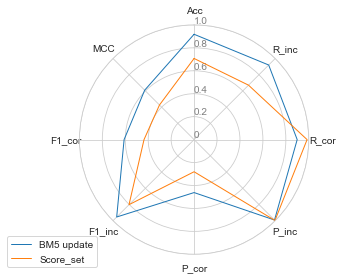

In [57]:
plot_radar(df_performance_FS,"Feature_selection_performance")